In [193]:
import numpy as np
import matplotlib.pyplot as plt
seed = 42

In [194]:
num_data = 1000
num_dim = 10
k = 5
np.random.seed(seed)
x = np.random.exponential(0.1, (num_data, num_dim))
y = np.zeros(num_data)
for i in range(k):
    x[i * 200:(i + 1) * 200, i * 2:(i + 1) * 2] += np.random.normal(1, 1, (200, 2))
    y[i * 200:(i + 1) * 200] = i


In [195]:
from sklearn.cluster import MiniBatchKMeans

In [196]:
km = MiniBatchKMeans(
    k, 
    #init='random'
).fit(x)
y_ = km.predict(x)

In [197]:
from scipy.optimize import linear_sum_assignment as lsa
from sklearn.metrics import confusion_matrix

def get_accuracy(y, y_):
    m = confusion_matrix(y, y_)
    i, j = lsa(-m)
    return m[i, j].sum() / y.shape[0]

In [198]:
get_accuracy(y, y_)

0.783

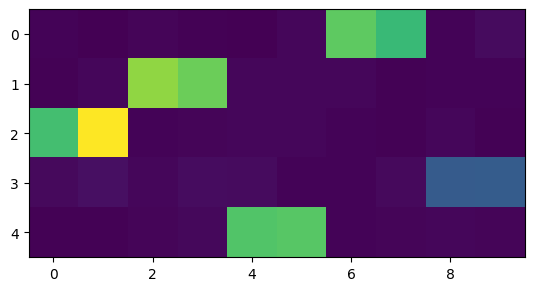

In [199]:
plt.imshow(km.cluster_centers_)

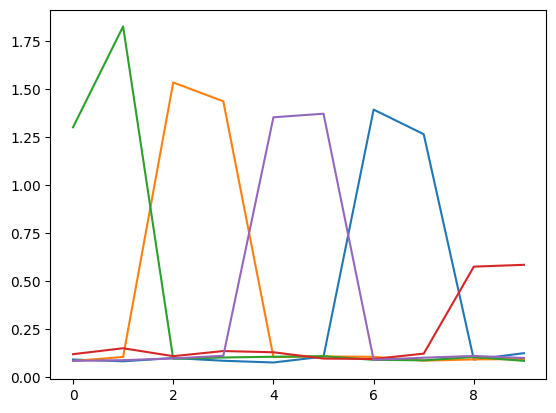

In [200]:
plt.plot(km.cluster_centers_.T)
plt.show()

In [ ]:
km.inertia_

1815.856134626918

In [ ]:
def inertia(km, x):
    wcss = 0
    y_ = km.predict(x)
    for i in range(km.cluster_centers_.shape[0]):
        ind = y_ == i
        wcss += np.sum((km.cluster_centers_[i] - x[ind]) ** 2)
    return wcss

inertia(km, x)


1815.856134626918

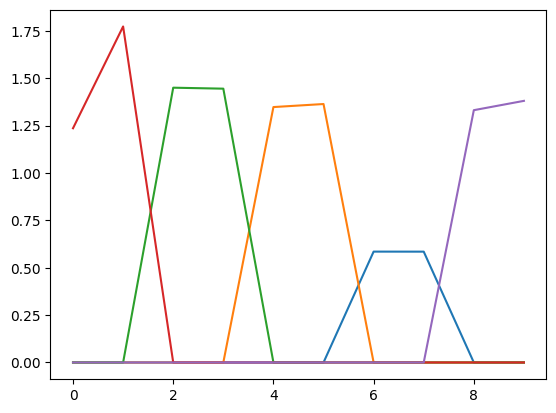

In [ ]:
centers = km.cluster_centers_.copy()
for i in range(centers.shape[0]):
    ind = centers[i] < np.quantile(centers[i], .8)
    centers[i, ind] *= 0

plt.plot(centers.T)
plt.show()

In [ ]:
km.cluster_centers_ = centers
y_ = km.predict(x)
get_accuracy(y, y_), inertia(km, x)

(0.808, 1903.1298152266518)

In [ ]:
km = MiniBatchKMeans(
    k, 
    init=centers
).fit(x)
y_ = km.predict(x)
get_accuracy(y, y_), inertia(km, x)

/home/cool_klindt/anaconda3/envs/pytorch/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1745: RuntimeWarning: Explicit initial center position passed: performing only one init in MiniBatchKMeans instead of n_init=3.
  super()._check_params(X)


(0.803, 1816.1575489486277)

In [ ]:
ind = np.random.choice(num_data, k, replace=False)
centers = x[ind].copy()
centers.shape

(5, 10)

In [ ]:
# assign
distances = np.sum((centers[:, None] - x[None]) ** 2, 2) ** .5
print(distances.shape)

new_label = distances.argmin(0)
new_label.shape, get_accuracy(y, new_label)

(5, 1000)


((1000,), 0.587)

In [ ]:
# update
for i in range(k):
    ind = new_label == i
    centers[i] = np.mean(x[ind])

In [ ]:
np.random.seed(seed + 235)
ind = np.random.choice(num_data, k, replace=False)
centers = x[ind].copy()

#centers = km.cluster_centers_.copy()

label = np.zeros(num_data)
for i in range(100):
    distances = np.sum((centers[:, None] - x[None]) ** 2, 2) ** .5
    new_label = distances.argmin(0)
    if np.all(label == new_label):
        break
    print(i, get_accuracy(y, new_label))
    for j in range(k):
        ind = new_label == j
        centers[j] = np.mean(x[ind], 0)
    label = new_label

    

0 0.473
1 0.586
2 0.597
3 0.612
4 0.619
5 0.623
6 0.634
7 0.647
8 0.654
9 0.667
10 0.685
11 0.73
12 0.776
13 0.786
14 0.784
15 0.785


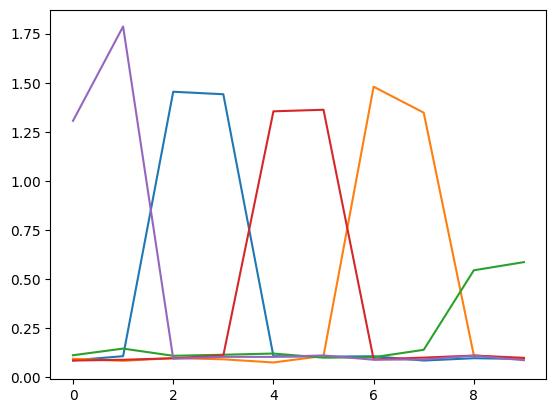

In [ ]:
plt.plot(centers.T)
plt.show()

In [ ]:
km.cluster_centers_ = centers
inertia(km, x)

1794.0268196037875

In [ ]:
def my_kmeans(x, k, num_init, sparsity=0, top_k=None, seed=seed, verbose=True):
    all_centers, inertias = [], []
    num_data = x.shape[0]
    if top_k is not None:
        assert top_k > 0 and top_k < x.shape[1]

    for init in range(num_init):
        np.random.seed(seed + init)
        ind = np.random.choice(num_data, k, replace=False)
        centers = x[ind].copy()
        label = np.zeros(num_data)
        for i in range(100):
            distances = np.sum((centers[:, None] - x[None]) ** 2, 2) ** .5
            new_label = distances.argmin(0)
            if np.all(label == new_label):
                break
            for j in range(k):
                ind = new_label == j
                centers[j] = np.mean(x[ind], 0)

                #if sparsity > 0:
                #    ind = centers[j] < np.quantile(centers[j], sparsity)
                #    centers[j, ind] *= 0

                if top_k is not None:
                    ind = np.argsort(centers[j])[:-top_k]
                    centers[j][ind] *= 0

            label = new_label
        km.cluster_centers_ = centers
        inertias.append(inertia(km, x))
        all_centers.append(centers.copy())
        if verbose:
            print('init', init, 'inertia', inertias[-1], 
                'converged at', i, 
                'acc', get_accuracy(y, new_label))
    return all_centers[np.argmin(inertias)]
    

In [ ]:
centers = my_kmeans(x, k, num_init=10, top_k=None, seed=seed)

init 0 inertia 2544.7495626678265 converged at 13 acc 0.369
init 1 inertia 2155.7194540936534 converged at 10 acc 0.599
init 2 inertia 2091.233968760228 converged at 8 acc 0.594
init 3 inertia 2495.9077535569877 converged at 12 acc 0.386
init 4 inertia 2256.616789338966 converged at 21 acc 0.599
init 5 inertia 2096.810926726084 converged at 9 acc 0.586
init 6 inertia 2567.2560272356573 converged at 16 acc 0.385
init 7 inertia 1794.046389549985 converged at 9 acc 0.787
init 8 inertia 1815.290397431686 converged at 7 acc 0.787
init 9 inertia 1843.1347925605357 converged at 10 acc 0.804


In [ ]:
centers = my_kmeans(x, k, num_init=20, top_k=5, seed=seed)

init 0 inertia 2666.2902808313584 converged at 14 acc 0.375
init 1 inertia 2201.1447181549565 converged at 8 acc 0.606
init 2 inertia 2138.4922895958357 converged at 7 acc 0.6
init 3 inertia 2617.7426010039762 converged at 12 acc 0.39
init 4 inertia 2502.7650625318142 converged at 12 acc 0.447
init 5 inertia 2143.652265840451 converged at 7 acc 0.588
init 6 inertia 2688.6465960075093 converged at 12 acc 0.385
init 7 inertia 1841.3272702285424 converged at 7 acc 0.801
init 8 inertia 1861.9661544384862 converged at 13 acc 0.802
init 9 inertia 1888.8518059270643 converged at 10 acc 0.811
init 10 inertia 2135.374986332009 converged at 12 acc 0.586
init 11 inertia 1888.8860597755963 converged at 5 acc 0.807
init 12 inertia 2199.559520445183 converged at 6 acc 0.583
init 13 inertia 2112.9157869237047 converged at 10 acc 0.604
init 14 inertia 1861.986594877131 converged at 11 acc 0.8
init 15 inertia 2111.99364404683 converged at 9 acc 0.588
init 16 inertia 1908.1476245128333 converged at 20 a

In [ ]:
centers = my_kmeans(x, k, num_init=20, top_k=2, seed=seed)

init 0 inertia 2990.3422200474392 converged at 10 acc 0.368
init 1 inertia 2462.0718805471097 converged at 9 acc 0.596
init 2 inertia 2386.8722802941998 converged at 9 acc 0.592
init 3 inertia 2941.2296491164257 converged at 16 acc 0.383
init 4 inertia 2504.8168989900496 converged at 8 acc 0.599
init 5 inertia 2392.3447614663432 converged at 8 acc 0.582
init 6 inertia 3019.9905930865802 converged at 12 acc 0.377
init 7 inertia 1882.1342484990219 converged at 6 acc 0.812
init 8 inertia 1900.928005085433 converged at 6 acc 0.82
init 9 inertia 1927.99597102212 converged at 9 acc 0.815
init 10 inertia 2382.606654754486 converged at 10 acc 0.582
init 11 inertia 1927.99597102212 converged at 4 acc 0.815
init 12 inertia 2466.4035631420925 converged at 9 acc 0.58
init 13 inertia 2428.1951467486115 converged at 6 acc 0.606
init 14 inertia 1900.648464731609 converged at 8 acc 0.824
init 15 inertia 2358.8524528224557 converged at 7 acc 0.583
init 16 inertia 1944.7980829804592 converged at 10 acc 

In [ ]:
centers = my_kmeans(x, k, num_init=20, top_k=1, seed=seed)

init 0 inertia 3278.1764745523424 converged at 4 acc 0.375
init 1 inertia 3236.7908390150556 converged at 10 acc 0.54
init 2 inertia 3073.8250697144767 converged at 6 acc 0.547
init 3 inertia 3201.8642262314315 converged at 6 acc 0.373
init 4 inertia 3059.006807021642 converged at 14 acc 0.526
init 5 inertia 3019.8628594798356 converged at 5 acc 0.543
init 6 inertia 3296.745428646472 converged at 8 acc 0.38
init 7 inertia 2876.9508174865937 converged at 7 acc 0.718
init 8 inertia 2894.820703710815 converged at 7 acc 0.712
init 9 inertia 2914.2446010025246 converged at 8 acc 0.699
init 10 inertia 3080.37477434423 converged at 6 acc 0.539
init 11 inertia 2914.248023412891 converged at 7 acc 0.7
init 12 inertia 3053.9235985945907 converged at 5 acc 0.53
init 13 inertia 3071.998508179053 converged at 8 acc 0.554
init 14 inertia 2897.5383172229344 converged at 7 acc 0.7
init 15 inertia 2975.5418905748948 converged at 5 acc 0.54
init 16 inertia 2976.558958216241 converged at 12 acc 0.717
ini

In [ ]:
top_ks = np.arange(1, num_dim)
inertias, accs = [], []
for top_k in top_ks:
    centers = my_kmeans(x, k, num_init=100, top_k=top_k, seed=seed, verbose=False)
    km.cluster_centers_ = centers
    y_ = km.predict(x)
    inertias.append(inertia(km, x))
    accs.append(get_accuracy(y, y_))
    print(top_k, inertias[-1], accs[-1])

1 2876.9014534390694 0.711
2 1882.1342484990219 0.812
3 1867.3567047310707 0.808
4 1853.2478742240642 0.804
5 1841.3272702285421 0.801
6 1830.2525578608813 0.801
7 1819.9244817809756 0.8
8 1810.5322330749093 0.79
9 1801.797910090951 0.789


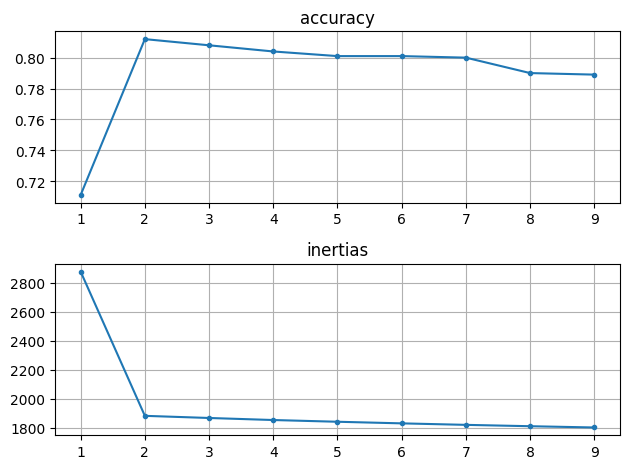

In [ ]:
plt.subplot(2, 1, 1)
plt.plot(top_ks, accs, '.-')
plt.title('accuracy')
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(top_ks, inertias, '.-')
plt.title('inertias')
plt.grid()

plt.tight_layout()

# Load some data

In [202]:
%load_ext autoreload
%autoreload 2

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib import cm

from scipy.stats import mode
from sklearn.manifold import TSNE
from sklearn.cluster import MiniBatchKMeans
from scipy.stats import pearsonr as corr

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

global_seed = 20230831

from main_cifar10 import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using device: cuda


In [203]:
log_dir = 'results/test4/'
with open(os.path.join(log_dir, 'results.pkl'), 'rb') as f:
    results = pickle.load(f)

results['layer1'].keys()

dict_keys(['output_shape', 'activations', 'activations_normed', 'kmeans_num_dic', 'kmeans_128', 'kmeans_128dist', 'kmeans_256', 'kmeans_256dist', 'kmeans_512', 'kmeans_512dist', 'data_train', 'data_test', 'data_train_kmeans_128', 'data_test_kmeans_128', 'data_train_kmeans_256', 'data_test_kmeans_256', 'data_train_kmeans_512', 'data_test_kmeans_512', 'probabilities', 'probabilities_kmeans_128', 'probabilities_kmeans_256', 'probabilities_kmeans_512', 'monosemanticity', 'monosemanticity_kmeans_128', 'monosemanticity_kmeans_256', 'monosemanticity_kmeans_512', 'kmeans_128_top', 'kmeans_128_topdist', 'data_train_kmeans_128_top', 'data_test_kmeans_128_top', 'monosemanticity_kmeans_128_top', 'kmeans_128_bottom', 'kmeans_128_bottomdist', 'data_train_kmeans_128_bottom', 'data_test_kmeans_128_bottom', 'monosemanticity_kmeans_128_bottom', 'kmeans_256_top', 'kmeans_256_topdist', 'data_train_kmeans_256_top', 'data_test_kmeans_256_top', 'monosemanticity_kmeans_256_top', 'kmeans_256_bottom', 'kmeans_2

In [205]:
x = results['layer1']['activations'].copy()
k = 256
x.shape

(50000, 256)

In [206]:
km = MiniBatchKMeans(
    k, 
    #init='random',
    verbose=True
).fit(x)
y_ = km.predict(x)
km.inertia_

Init 1/3 with method k-means++
Inertia for init 1/3: 259.4013366699219
Init 2/3 with method k-means++
Inertia for init 2/3: 260.4638977050781
Init 3/3 with method k-means++
Inertia for init 3/3: 260.5476989746094
[MiniBatchKMeans] Reassigning 36 cluster centers.
Minibatch step 1/4882: mean batch inertia: 0.08312132954597473
Minibatch step 2/4882: mean batch inertia: 0.07171325385570526, ewa inertia: 0.07171325385570526
Minibatch step 3/4882: mean batch inertia: 0.06794825941324234, ewa inertia: 0.07155904276756374
Minibatch step 4/4882: mean batch inertia: 0.06704515218734741, ewa inertia: 0.07137415750710328
Minibatch step 5/4882: mean batch inertia: 0.06669668853282928, ewa inertia: 0.07118257220962297
Minibatch step 6/4882: mean batch inertia: 0.06575191766023636, ewa inertia: 0.07096013704798332
[MiniBatchKMeans] Reassigning 23 cluster centers.
Minibatch step 7/4882: mean batch inertia: 0.06594383716583252, ewa inertia: 0.0707546735140811
Minibatch step 8/4882: mean batch inertia: 

3038.5556640625

In [273]:
def my_kmeans(
        x, k, km, num_init, convergence=0.95,
        batch_size=0, lr=1.0,
        top_k=None, seed=seed, verbose=True,
    ):
        
    num_data = x.shape[0]
    if top_k is not None:
        assert top_k > 0 and top_k < x.shape[1]

    for init in range(num_init):
        np.random.seed(seed + init)
        ind = np.random.choice(num_data, k, replace=False)
        centers = x[ind].copy()

        # sparsify
        if top_k is not None:
            for j in range(k):
                ind = np.argsort(centers[j])[:-top_k]
                centers[j][ind] *= 0

        ind = np.random.choice(num_data, 10 * k, replace=False)
        val_batch = x[ind]
        km.cluster_centers_ = centers
        val_inertia0 = inertia(km, val_batch)

        for i in range(100):

            if batch_size > 0:
                np.random.seed(seed + 2349872 + i)
                ind = np.random.choice(num_data, batch_size, replace=False)
                batch = x[ind]
            else:
                batch = x

            # current label
            distances = np.sum((centers[:, None] - batch[None]) ** 2, 2)
            current_label = distances.argmin(0)
            distances = np.sum((centers[:, None] - val_batch[None]) ** 2, 2)
            current_val_label = distances.argmin(0)
            
            # update centers
            for j in range(k):
                ind = current_label == j
                if np.sum(ind) > 10:
                    update = np.mean(batch[ind], 0)
                    centers[j] = (1 - lr) * centers[j] + lr * update
                # sparsify
                if top_k is not None:
                    ind = np.argsort(centers[j])[:-top_k]
                    centers[j][ind] *= 0

            # new label
            distances = np.sum((centers[:, None] - batch[None]) ** 2, 2)
            new_label = distances.argmin(0)
            distances = np.sum((centers[:, None] - val_batch[None]) ** 2, 2)
            new_val_label = distances.argmin(0)

            km.cluster_centers_ = centers
            val_inertia = inertia(km, val_batch)

            if verbose:
                counts = np.unique(current_val_label, return_counts=True)[1]
                print(
                    'init', init, 'step', i, 'val_inertia=%.4f' % val_inertia,
                    'converged=%s' % np.mean(current_val_label == new_val_label),
                    'counts: min=%.4f, max=%.4f, std=%.4f' % (
                        counts.min(), counts.max(), counts.std()
                    )
                )
                
            #if np.mean(current_val_label == new_val_label) > convergence:
            #    break
            if val_inertia > val_inertia0:
                break
            else:
                val_inertia0 = val_inertia

        km.cluster_centers_ = centers
        inertias.append(inertia(km, x))
        all_centers.append(centers.copy())
        if verbose:
            print('init', init, 'inertia', inertias[-1], 
                'converged at', i, 
            )
    return all_centers[np.argmin(inertias)]
    

In [269]:
centers = my_kmeans(
    x, k, km, num_init=3, convergence=0.95,
    batch_size=1000, lr=0.3,
    top_k=None, seed=seed, verbose=True,
)

init 0 step 0 val_inertia=220.1019 converged=0.826171875 counts: min=1.0000, max=64.0000, std=10.9169
init 0 step 1 val_inertia=213.4327 converged=0.8734375 counts: min=1.0000, max=95.0000, std=15.5591
init 0 step 2 val_inertia=208.9424 converged=0.89296875 counts: min=1.0000, max=124.0000, std=19.1509
init 0 step 3 val_inertia=205.6518 converged=0.89921875 counts: min=1.0000, max=139.0000, std=21.6006
init 0 step 4 val_inertia=203.3942 converged=0.918359375 counts: min=1.0000, max=135.0000, std=23.3719
init 0 step 5 val_inertia=201.4269 converged=0.91953125 counts: min=1.0000, max=143.0000, std=24.7595
init 0 step 6 val_inertia=200.2644 converged=0.937890625 counts: min=1.0000, max=145.0000, std=25.6300
init 0 step 7 val_inertia=199.6040 converged=0.935546875 counts: min=1.0000, max=137.0000, std=26.0404
init 0 step 8 val_inertia=199.1026 converged=0.93984375 counts: min=1.0000, max=139.0000, std=26.5048
init 0 step 9 val_inertia=198.5892 converged=0.941796875 counts: min=1.0000, max=

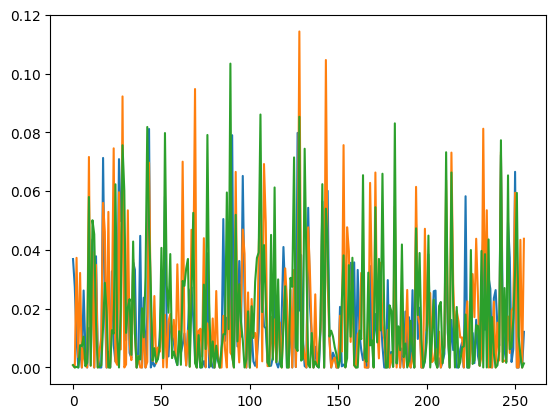

In [270]:
plt.plot(centers[:3].T)

In [274]:
centers_sparse = my_kmeans(
    x, k, km, num_init=3, convergence=0.95,
    batch_size=1000, lr=0.3,
    top_k=2, seed=seed, verbose=True,
)

init 0 step 0 val_inertia=424.8906 converged=0.9921875 counts: min=1.0000, max=61.0000, std=9.9021
init 0 step 1 val_inertia=424.8598 converged=0.98828125 counts: min=1.0000, max=62.0000, std=9.9655
init 0 step 2 val_inertia=424.8351 converged=0.991796875 counts: min=1.0000, max=61.0000, std=9.9604
init 0 step 3 val_inertia=424.8121 converged=0.992578125 counts: min=1.0000, max=62.0000, std=9.9442
init 0 step 4 val_inertia=424.7930 converged=0.9890625 counts: min=1.0000, max=61.0000, std=9.9309
init 0 step 5 val_inertia=424.7575 converged=0.989453125 counts: min=1.0000, max=60.0000, std=9.9450
init 0 step 6 val_inertia=424.7305 converged=0.990625 counts: min=1.0000, max=60.0000, std=9.9992
init 0 step 7 val_inertia=424.7200 converged=0.994140625 counts: min=1.0000, max=59.0000, std=9.9630
init 0 step 8 val_inertia=424.7112 converged=0.9953125 counts: min=1.0000, max=59.0000, std=9.9826
init 0 step 9 val_inertia=424.7042 converged=0.98828125 counts: min=1.0000, max=58.0000, std=9.9013
i

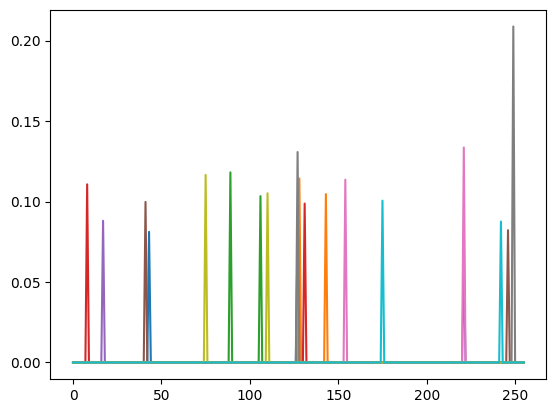

In [275]:
plt.plot(centers_sparse[:10].T)

### Full Batch

In [236]:
centers = my_kmeans(
    x, k, km, num_init=3, batch_size=0,
    top_k=None, seed=seed, verbose=True,
)

init 0 step 0 batch_inertia=3202.0816 converged=0.61114 counts: min=3.0000, max=1282.0000, mean=195.3125, std=208.6575,
init 0 step 1 batch_inertia=3100.4285 converged=0.81092 counts: min=5.0000, max=822.0000, mean=195.3125, std=122.1658,
init 0 step 2 batch_inertia=3060.7202 converged=0.87808 counts: min=8.0000, max=657.0000, mean=195.3125, std=100.1910,
init 0 step 3 batch_inertia=3039.7109 converged=0.91056 counts: min=13.0000, max=560.0000, mean=195.3125, std=91.2935,
init 0 step 4 batch_inertia=3026.0745 converged=0.93216 counts: min=25.0000, max=537.0000, mean=195.3125, std=86.7737,
init 0 step 5 batch_inertia=3016.5509 converged=0.94364 counts: min=34.0000, max=521.0000, mean=195.3125, std=83.9655,
init 0 step 6 batch_inertia=3009.6392 converged=0.95364 counts: min=44.0000, max=506.0000, mean=195.3125, std=82.1676,
init 0 inertia 3009.639184951782 converged at 6
init 1 step 0 batch_inertia=3209.2794 converged=0.61698 counts: min=3.0000, max=1320.0000, mean=195.3125, std=185.2777

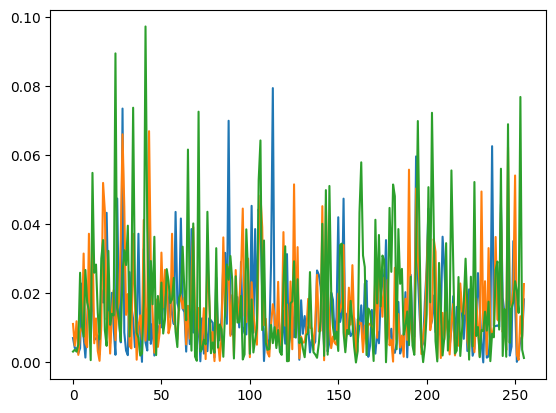

In [239]:
plt.plot(centers[:3].T)

In [240]:
centers_sparse = my_kmeans(
    x, k, km, num_init=3, batch_size=0,
    top_k=2, seed=seed, verbose=True,
)

init 0 step 0 batch_inertia=8203.4996 converged=0.12284 counts: min=3.0000, max=1282.0000, mean=195.3125, std=208.6575,
init 0 step 1 batch_inertia=8168.6964 converged=0.81528 counts: min=7.0000, max=899.0000, mean=195.3125, std=156.9292,
init 0 step 2 batch_inertia=8162.8406 converged=0.9202 counts: min=7.0000, max=904.0000, mean=195.3125, std=142.9744,
init 0 step 3 batch_inertia=8160.3977 converged=0.94754 counts: min=8.0000, max=900.0000, mean=195.3125, std=138.2562,
init 0 step 4 batch_inertia=8158.4592 converged=0.96324 counts: min=13.0000, max=882.0000, mean=195.3125, std=134.7268,
init 0 inertia 8158.459240436554 converged at 4
init 1 step 0 batch_inertia=8205.9730 converged=0.13876 counts: min=3.0000, max=1320.0000, mean=195.3125, std=185.2777,
init 1 step 1 batch_inertia=8167.6779 converged=0.80112 counts: min=8.0000, max=929.0000, mean=195.3125, std=148.1013,
init 1 step 2 batch_inertia=8163.8169 converged=0.91954 counts: min=11.0000, max=780.0000, mean=195.3125, std=130.967

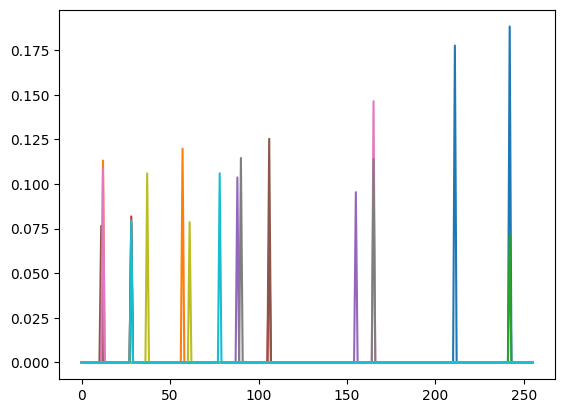

In [241]:
plt.plot(centers_sparse[:10].T)

In [294]:
from sparse_batched_kmeans import SparseMiniBatchKMeans

In [295]:
km_sparse = SparseMiniBatchKMeans(
    n_clusters=256,
    n_init=3,
    batch_size=1024,
    lr=0.3,
    max_iter=100,
    top_k=5,  # how many coefficients to leave active
    random_state=42,
    verbose=True
)

In [296]:
km_sparse.fit(x)

Fitting Dense MiniBatchKMeans
Init 1/3 with method k-means++
Inertia for init 1/3: 260.16009521484375
Init 2/3 with method k-means++
Inertia for init 2/3: 263.52044677734375
Init 3/3 with method k-means++
Inertia for init 3/3: 260.7679443359375
[MiniBatchKMeans] Reassigning 44 cluster centers.
Minibatch step 1/4882: mean batch inertia: 0.0839448794722557
Minibatch step 2/4882: mean batch inertia: 0.07381226867437363, ewa inertia: 0.07381226867437363
Minibatch step 3/4882: mean batch inertia: 0.06828349083662033, ewa inertia: 0.07358581446322347
Minibatch step 4/4882: mean batch inertia: 0.06664755940437317, ewa inertia: 0.07330162921971782
Minibatch step 5/4882: mean batch inertia: 0.06609296053647995, ewa inertia: 0.07300636805567567
Minibatch step 6/4882: mean batch inertia: 0.06395865231752396, ewa inertia: 0.07263578103078147
[MiniBatchKMeans] Reassigning 22 cluster centers.
Minibatch step 7/4882: mean batch inertia: 0.06706751883029938, ewa inertia: 0.07240770957247888
Minibatch s

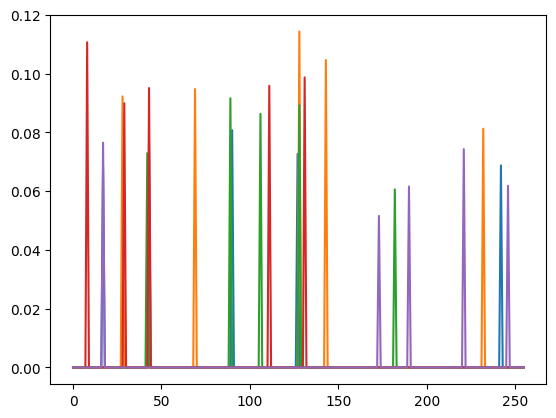

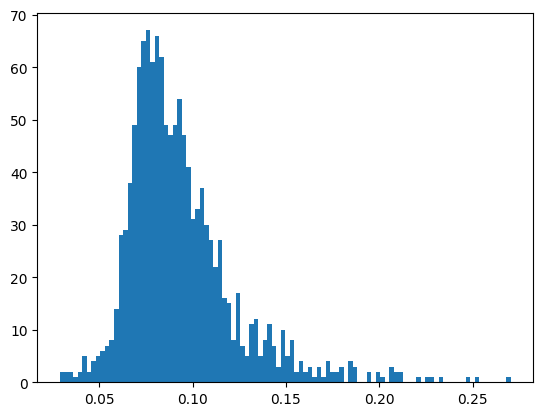

In [297]:
plt.plot(km_sparse.cluster_centers_[:5].T)
plt.show()

tmp = km_sparse.cluster_centers_.flatten().copy()
tmp = tmp[tmp > 0]
plt.hist(tmp, 100)
plt.show()

In [299]:
distances = km_sparse.transform(x)
distances.shape

(50000, 256)

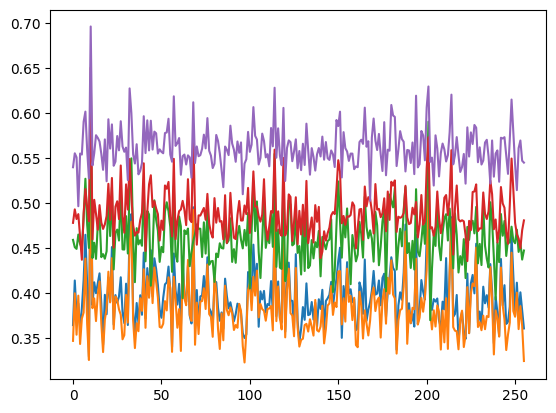

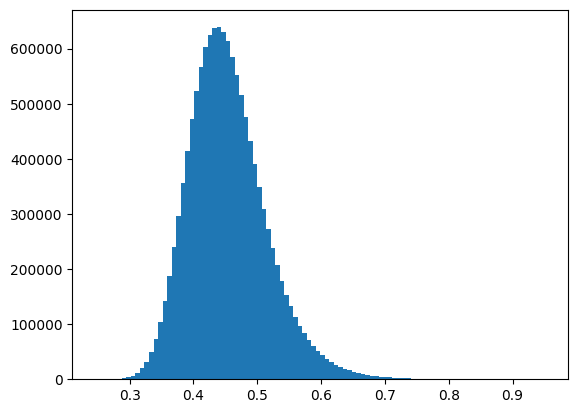

In [300]:
plt.plot(distances[:5].T)
plt.show()

plt.hist(distances.flatten(), 100)
plt.show()

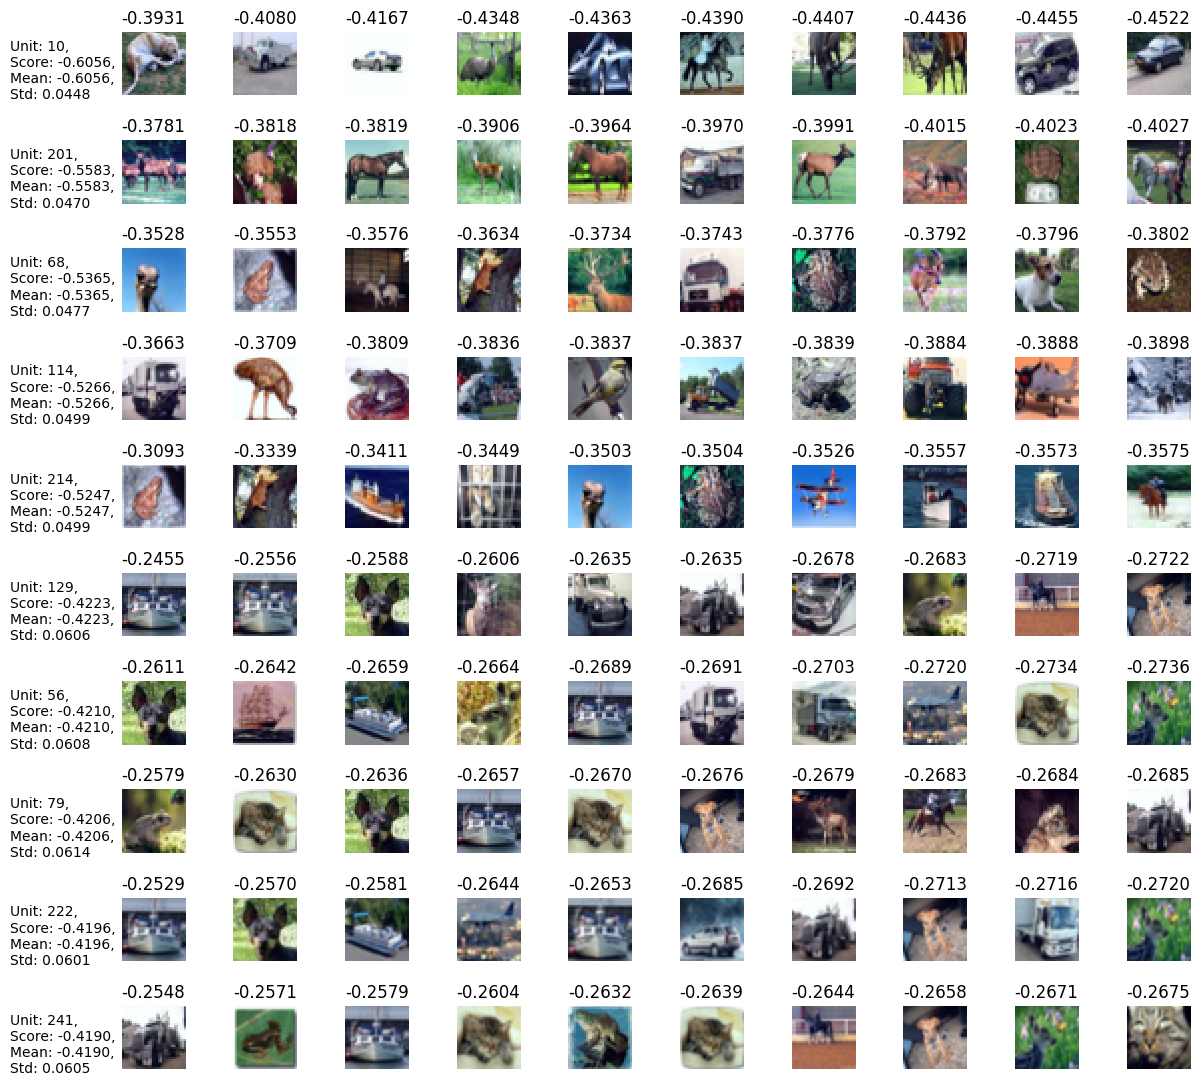

In [301]:
plot_meis(
    -distances,
    -distances.mean(0),
    results['inputs'],
    '', plot=True
)

In [302]:
data_train, data_test = get_mei_data(
    -distances, results['inputs']
)

In [303]:
scores = get_monosemanticity(data_train)

{'whiskers': [<matplotlib.lines.Line2D at 0x7f4ab82c3340>,
 'caps': [<matplotlib.lines.Line2D at 0x7f4ab82c0ac0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f4ab82c3100>,
 'medians': [<matplotlib.lines.Line2D at 0x7f4ab82c14e0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f4ab82c2890>,
 'means': []}

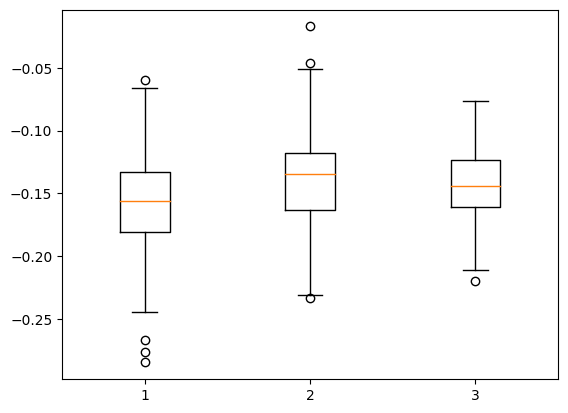

In [304]:
plt.boxplot([
    -results['layer1']['monosemanticity'],
    -results['layer1']['monosemanticity_kmeans_256'],
    -scores
])

# Experiment over sparsity

In [293]:
scores = []
top_ks = np.arange(20, 0, -2)
km_sparse = SparseMiniBatchKMeans(
    n_clusters=256,
    n_init=3,
    batch_size=1024,
    lr=0.3,
    max_iter=100,
    top_k=1,  # how many coefficients to leave active
    random_state=42,
    verbose=True
)
for i, top_k in enumerate(top_ks):
    print(i, top_k)
    km_sparse.top_k = top_k
    if i == 0:
        km_dense = None
    else:
        km_dense = km_sparse.km_dense
    km_sparse.fit(x, km_dense=km_dense)
    print(i, top_k, km_sparse.inertia_)
    distances = km_sparse.transform(x)
    data_train, data_test = get_mei_data(
        -distances, results['inputs']
    )
    scores.append(get_monosemanticity(data_train))
    print('\n\n SCORE: ', scores[-1].mean(), scores[-1].std(), '\n\n')


0 20
Fitting Dense MiniBatchKMeans
Init 1/3 with method k-means++
Inertia for init 1/3: 262.7601318359375
Init 2/3 with method k-means++
Inertia for init 2/3: 258.73895263671875
Init 3/3 with method k-means++
Inertia for init 3/3: 261.072998046875
[MiniBatchKMeans] Reassigning 37 cluster centers.
Minibatch step 1/4882: mean batch inertia: 0.08450205624103546
Minibatch step 2/4882: mean batch inertia: 0.07097284495830536, ewa inertia: 0.07097284495830536
Minibatch step 3/4882: mean batch inertia: 0.06812413781881332, ewa inertia: 0.07085616424748598
[MiniBatchKMeans] Reassigning 40 cluster centers.
Minibatch step 4/4882: mean batch inertia: 0.06581804156303406, ewa inertia: 0.07064980686947837
Minibatch step 5/4882: mean batch inertia: 0.06557946652173996, ewa inertia: 0.07044212988237475
Minibatch step 6/4882: mean batch inertia: 0.06771356612443924, ewa inertia: 0.07033037014604443
Minibatch step 7/4882: mean batch inertia: 0.06530234962701797, ewa inertia: 0.07012442654445714
Minibat

KeyboardInterrupt: 

In [ ]:
plt.plot(top_ks, [_.mean() for _ in scores], '.-')